## Create Chunked Dataset

In [1]:
import os
import getpass

from datasets import load_dataset, DatasetDict
from huggingface_hub import login
from transformers import AutoTokenizer
from dotenv import load_dotenv
import matplotlib.pyplot as plt


In [2]:

load_dotenv('.envrc')
if 'HF_TOKEN' in os.environ:
    login(token=os.environ['HF_TOKEN'])
else:
    login(token=getpass.getpass('Huggingface token: '))

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [3]:
# DATASET_REPO = 'roneneldan/TinyStories'
# STORY_KEY = 'text'
DATASET_REPO = 'SimpleStories/SimpleStories'
STORY_KEY = 'story'

CHUNK_LENGTH = 128

TOKENIZER_MODEL = 'SimpleStories/SimpleStories-35M'
TRAIN_SPLIT_PERCENTAGE = 4

In [4]:

dataset = load_dataset(DATASET_REPO, split='train')
print('Total rows:', len(dataset))


Total rows: 2115696


In [5]:
# tokenize the dataset  
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_MODEL)
tokenizer.pad_token = tokenizer.eos_token
def tokenize_function(examples):
    return tokenizer(examples[STORY_KEY], truncation=False, padding='do_not_pad')
tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=dataset.column_names).select_columns(['input_ids'])

tokenized_dataset

Dataset({
    features: ['input_ids'],
    num_rows: 2115696
})

In [6]:

train_dataset, val_dataset = tokenized_dataset.train_test_split(
    test_size=TRAIN_SPLIT_PERCENTAGE / 100,
    seed=42,
).values()

def chunk_dataset_with_map(dataset, token_column='input_ids', chunk_length=CHUNK_LENGTH):
    """
    Memory-efficient version using dataset.map() and batched processing.
    """
    
    def chunk_batch(batch):
        chunked_batch = {col: [] for col in batch.keys()}
        
        for i in range(len(batch[token_column])):
            tokens = batch[token_column][i]
            token_count = len(tokens)
            num_chunks = token_count // chunk_length
            
            for chunk_idx in range(num_chunks):
                start_idx = chunk_idx * chunk_length
                end_idx = start_idx + chunk_length
                chunk_tokens = tokens[start_idx:end_idx]
                
                # Add chunk to batch
                for col in batch.keys():
                    if col == token_column:
                        chunked_batch[col].append(chunk_tokens)
                    else:
                        chunked_batch[col].append(batch[col][i])
        
        return chunked_batch
    
    # Use map with batched=True for memory efficiency
    chunked_dataset = dataset.map(
        chunk_batch,
        batched=True,
        remove_columns=dataset.column_names,  # Remove original columns
        batch_size=1000,  # Adjust based on your memory constraints
    )
    
    return chunked_dataset
chunked_dataset_train = chunk_dataset_with_map(train_dataset, chunk_length=CHUNK_LENGTH)
chunked_dataset_val = chunk_dataset_with_map(val_dataset, chunk_length=CHUNK_LENGTH)

In [13]:
print("Train dataset length:", len(chunked_dataset_train))
print("Validation dataset length:", len(chunked_dataset_val))
DS_REPO_NAME = DATASET_REPO.replace('/', '-') + f'-chunked-{CHUNK_LENGTH}'

print(train_dataset)
print(val_dataset)

dict_dataset = DatasetDict({
    'train': chunked_dataset_train,
    'validation': chunked_dataset_val,
})

dict_dataset.push_to_hub(f"MikiV/{DS_REPO_NAME}", private=True)




Train dataset length: 3653646
Validation dataset length: 152426
Dataset({
    features: ['input_ids'],
    num_rows: 2031068
})
Dataset({
    features: ['input_ids'],
    num_rows: 84628
})


Uploading the dataset shards:   0%|          | 0/4 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

CommitInfo(commit_url='https://huggingface.co/datasets/MikiV/SimpleStories-SimpleStories-chunked-128/commit/370848d2c31cc4b44ebbd0fdd9282bfcdf73b806', commit_message='Upload dataset', commit_description='', oid='370848d2c31cc4b44ebbd0fdd9282bfcdf73b806', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/MikiV/SimpleStories-SimpleStories-chunked-128', endpoint='https://huggingface.co', repo_type='dataset', repo_id='MikiV/SimpleStories-SimpleStories-chunked-128'), pr_revision=None, pr_num=None)

## Dataset Exploration

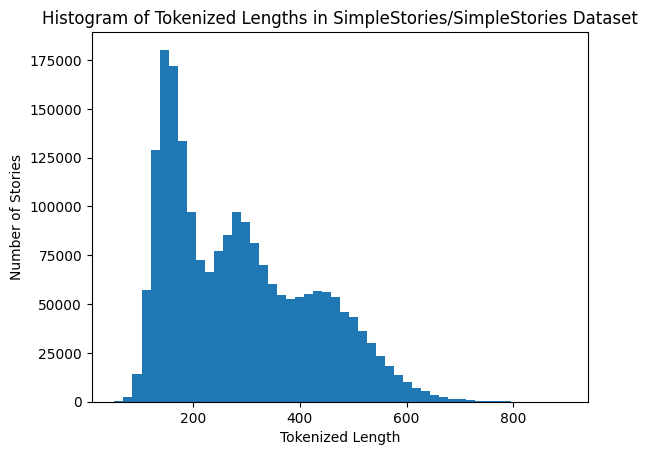

In [8]:
# Historgram of tokenized lengths
lengths = [len(x) for x in tokenized_dataset['input_ids']]
plt.hist(lengths, bins=50)
plt.xlabel('Tokenized Length')
plt.ylabel('Number of Stories')
plt.title(f'Histogram of Tokenized Lengths in {DATASET_REPO} Dataset')
plt.show()

In [9]:
total_tokens_train = len(chunked_dataset_train)*CHUNK_LENGTH/1e6
total_tokens_val = len(chunked_dataset_val)*CHUNK_LENGTH/1e6
total_tokens_original = sum(lengths)/1e6
print(f"Total available tokens = {total_tokens_original}M tokens")
print(f"Total tokens in chunked dataset (train) = {total_tokens_train}M tokens")
print(f"Total tokens in chunked dataset (test) = {total_tokens_val}M tokens")
print(f"We are left with {(total_tokens_train + total_tokens_val)/total_tokens_original * 100}% of the original tokens (train)")

Total available tokens = 608.617592M tokens
Total tokens in chunked dataset (train) = 467.666688M tokens
Total tokens in chunked dataset (test) = 19.510528M tokens
We are left with 80.04652221751752% of the original tokens (train)


In [10]:
for thresh in [64, 128, 256, 512]:
    x = sum(l >= thresh for l in lengths) / len(lengths) * 100
    print(f"{x}% of stories are at least {thresh} tokens")

99.9950370941761% of stories are at least 64 tokens
94.04508020055812% of stories are at least 128 tokens
52.60907049027838% of stories are at least 256 tokens
7.031728565918733% of stories are at least 512 tokens


In [11]:
tokenizer.get_vocab()

{'dimmed': 3876,
 'real': 925,
 'try': 964,
 '##ent': 163,
 'giggled': 1810,
 'can': 270,
 'figure': 1113,
 'maps': 3007,
 'zoomed': 2801,
 'wanted': 388,
 '##ged': 1869,
 '##ived': 2863,
 'adventures': 1015,
 'don': 1490,
 'rest': 2054,
 'cars': 3969,
 'hopes': 2067,
 'decide': 3666,
 'bran': 2282,
 'outs': 3539,
 'dimm': 3463,
 'fea': 1317,
 'ins': 3039,
 '##bles': 2571,
 'growing': 1962,
 'cla': 1581,
 'door': 675,
 'kingdom': 1320,
 'wished': 1144,
 'x': 55,
 'sprink': 3711,
 'hungry': 2694,
 'tripped': 3511,
 '##roud': 789,
 '##found': 2487,
 '##reat': 311,
 'pat': 685,
 'chair': 2927,
 'brea': 620,
 'retur': 613,
 'answered': 2794,
 'steps': 2595,
 'snowball': 2847,
 '##p': 75,
 'exchanged': 3217,
 'sibling': 2501,
 'scents': 4015,
 'dreamer': 3770,
 'join': 738,
 '##oney': 2759,
 'shin': 516,
 'larger': 3794,
 '##ences': 3560,
 'firef': 2892,
 'beautiful': 684,
 'watched': 668,
 'cry': 1119,
 'window': 1359,
 '##pped': 377,
 'rainbow': 1574,
 'should': 1099,
 'disc': 3990,
 'awa

In [12]:
# Ove chunked dataset, find the most common tokens and what percentage of the dataset they cover
from collections import Counter
all_tokens = [token for chunk in chunked_dataset['input_ids'] for token in chunk]
token_counts = Counter(all_tokens)
total_tokens = len(all_tokens)
most_common = token_counts.most_common(20)
for token, count in most_common:
    print(f"Token: {token} ({tokenizer.decode([token])}), Count: {count}, Percentage: {count/total_tokens*100:.2f}%")

NameError: name 'chunked_dataset' is not defined